# EDA (Data Sample 500k)

## 1. Data Overview & Booking Feasibility

In [2]:
import pandas as pd
import numpy as np

RAW_TRAIN_PATH = r"C:\Users\Inbal\Desktop\PM Inbal\aipm_course_exercises\datasets_expedia\train.csv"

RANDOM_SEED = 42
TARGET_ROWS = 500_000
CHUNKSIZE = 200_000

In [3]:
rng = np.random.default_rng(RANDOM_SEED)

kept_chunks = []
rows_kept = 0

for i, chunk in enumerate(pd.read_csv(RAW_TRAIN_PATH, chunksize=CHUNKSIZE), start=1):
    remaining = TARGET_ROWS - rows_kept
    if remaining <= 0:
        break
    
    # sample proportionally from each chunk
    frac = min(1.0, remaining / len(chunk))
    sampled = chunk.sample(frac=frac, random_state=RANDOM_SEED + i)
    
    kept_chunks.append(sampled)
    rows_kept += len(sampled)
    
    print(f"Chunk {i}: kept {rows_kept:,} rows")

df_large = pd.concat(kept_chunks, ignore_index=True)
df_large.shape


Chunk 1: kept 200,000 rows
Chunk 2: kept 400,000 rows
Chunk 3: kept 500,000 rows


(500000, 24)

In [4]:
df_large = pd.concat(kept_chunks, ignore_index=True)
df_large.shape

(500000, 24)

In [5]:
df_large.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-11-16 08:58:47,2,3,66,258,19931,2107.8684,574450,0,0,...,0,3,8814,1,0,1,4,51,197,30
1,2014-09-21 07:52:26,2,3,231,72,31451,NaN,388180,0,0,...,0,1,1795,1,0,1,3,99,1312,67
2,2014-07-15 23:11:55,18,2,119,0,27731,NaN,403838,1,1,...,0,1,8822,1,0,1,3,130,91,91
3,2013-12-12 02:17:02,2,3,66,174,26259,5071.5825,373889,0,0,...,1,2,8238,1,0,1,6,31,155,89
4,2014-12-10 11:24:35,2,3,66,174,18354,240.1524,318896,0,0,...,0,1,64421,6,0,2,2,50,369,20


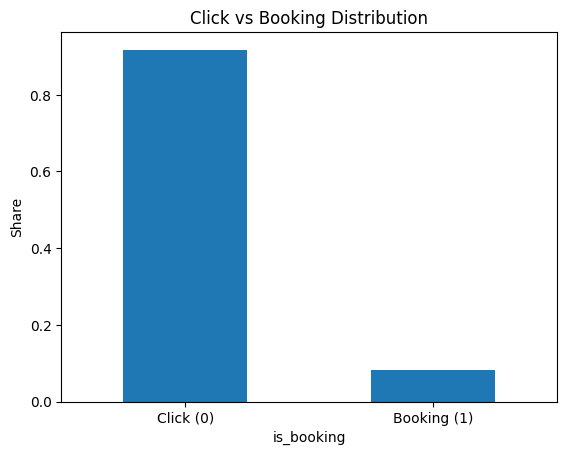

is_booking
0    0.917578
1    0.082422
Name: proportion, dtype: float64

In [6]:
import matplotlib.pyplot as plt

booking_dist = df_large["is_booking"].value_counts(normalize=True)

booking_dist.plot(kind="bar")
plt.title("Click vs Booking Distribution")
plt.ylabel("Share")
plt.xticks([0,1], ["Click (0)", "Booking (1)"], rotation=0)
plt.show()

booking_dist

The dataset is dominated by click events, while bookings represent a smaller but higher-value subset. This motivates focusing model training on booking events for business relevance.

In [7]:
df_bookings_large = df_large[df_large["is_booking"] == 1]
df_bookings_large.shape

(41211, 24)

In [8]:
df_bookings_large["hotel_cluster"].nunique()

100

In [9]:
cluster_counts = df_bookings_large["hotel_cluster"].value_counts()

cluster_counts.head(10)

hotel_cluster
91    1690
48    1223
42    1047
28     913
59     899
95     813
82     794
18     794
16     764
21     741
Name: count, dtype: int64

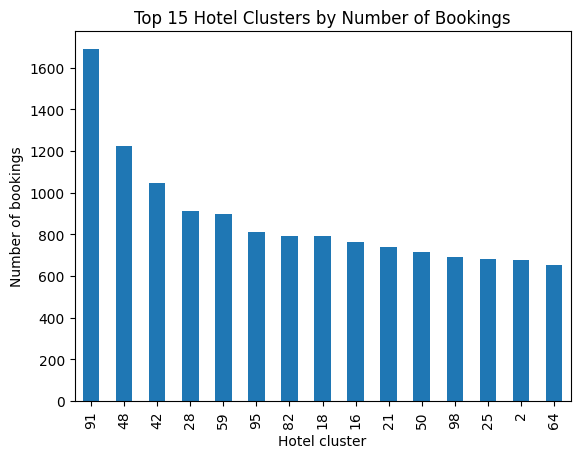

In [10]:
import matplotlib.pyplot as plt

cluster_counts.head(15).plot(kind="bar")
plt.title("Top 15 Hotel Clusters by Number of Bookings")
plt.ylabel("Number of bookings")
plt.xlabel("Hotel cluster")
plt.show()

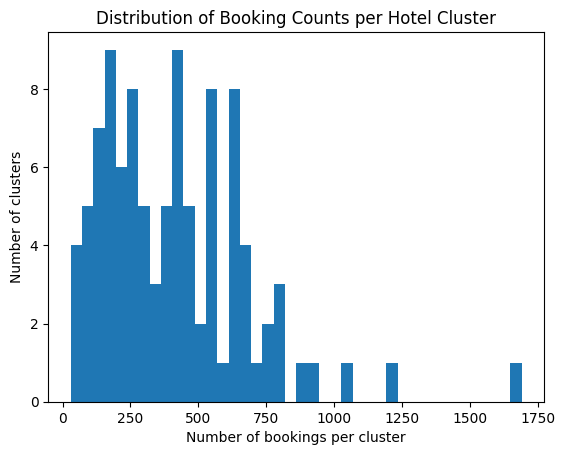

In [11]:
cluster_counts.plot(kind="hist", bins=40)
plt.title("Distribution of Booking Counts per Hotel Cluster")
plt.xlabel("Number of bookings per cluster")
plt.ylabel("Number of clusters")
plt.show()

##### Conclusion:
Filtering the dataset to booking events yields a sufficiently large and representative sample (≈41k bookings) covering all 100 hotel clusters.

The data exhibits strong class imbalance with a long-tail structure, making ranking-based evaluation more appropriate than single-label accuracy.

- Predicting a single cluster is fragile

- Ranking multiple likely clusters is more realistic

## 2. Feature Signal Exploration (Booking Events Only)

### 2.1 Geographic Signal

In [12]:
df_bookings_large["user_location_country"].value_counts().head(10)

user_location_country
66     24234
205     3715
69      3106
3       1147
46       919
77       786
215      692
1        650
133      556
23       310
Name: count, dtype: int64

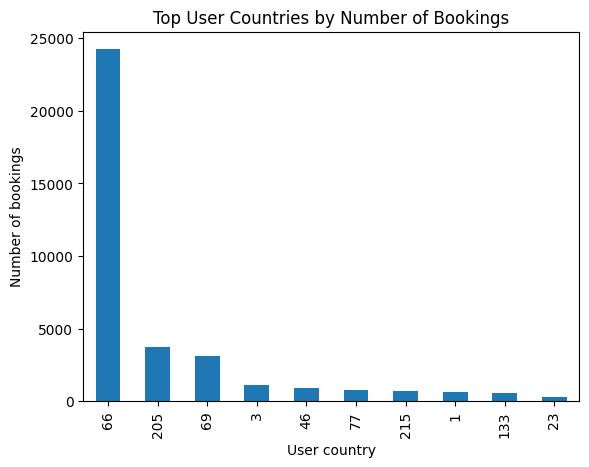

In [13]:
df_bookings_large["user_location_country"].value_counts().head(10).plot(kind="bar")
plt.title("Top User Countries by Number of Bookings")
plt.ylabel("Number of bookings")
plt.xlabel("User country")
plt.show()

User booking demand is highly skewed toward a small number of countries. This indicates that geographic context is a key determinant of hotel cluster choice and should be prioritized in feature selection and modeling.

In [14]:
pd.crosstab(
    df_bookings_large["user_location_country"],
    df_bookings_large["hotel_cluster"]
).loc[[66, 205, 69]].idxmax(axis=1)

user_location_country
66     91
205    91
69     64
dtype: int64

While the most popular hotel cluster is consistent across some countries, others exhibit distinct dominant cluster preferences, indicating geography-dependent ranking signals.

In [15]:
# the top-5 clusters for the dominant country (66)
pd.crosstab(
    df_bookings_large["user_location_country"],
    df_bookings_large["hotel_cluster"]
).loc[66].sort_values(ascending=False).head(5)

hotel_cluster
91    1397
48     969
42     821
28     626
18     579
Name: 66, dtype: int64

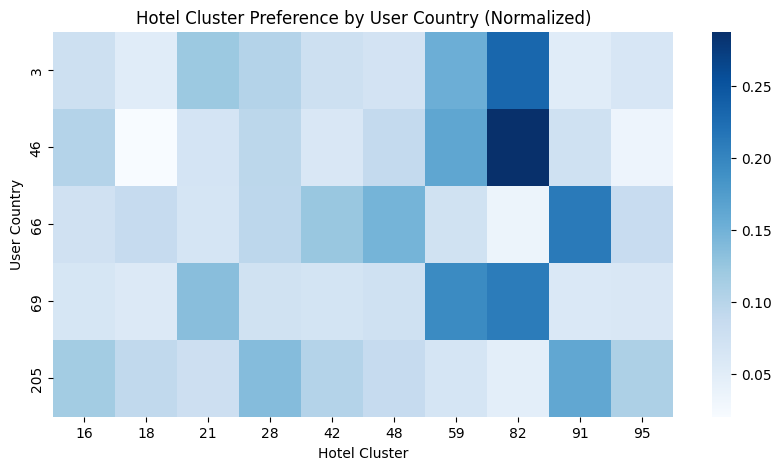

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# pick top countries to keep it readable
top_countries = (
    df_bookings_large["user_location_country"]
    .value_counts()
    .head(5)
    .index
)

# pick top clusters overall
top_clusters = (
    df_bookings_large["hotel_cluster"]
    .value_counts()
    .head(10)
    .index
)

# filter data
df_geo = df_bookings_large[
    df_bookings_large["user_location_country"].isin(top_countries)
    & df_bookings_large["hotel_cluster"].isin(top_clusters)
]

# pivot table: country x cluster
pivot = pd.pivot_table(
    df_geo,
    index="user_location_country",
    columns="hotel_cluster",
    values="is_booking",
    aggfunc="count",
    fill_value=0
)

# normalize per country to show ranking preference (important!)
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

# plot
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_norm, cmap="Blues")
plt.title("Hotel Cluster Preference by User Country (Normalized)")
plt.xlabel("Hotel Cluster")
plt.ylabel("User Country")
plt.show()


In [37]:
import pandas as pd

top3 = (
    pivot_norm
    .stack()                               # wide -> long (drops NaNs)
    .reset_index()
    .rename(columns={
        "user_location_country": "country",
        "hotel_cluster": "cluster",
        0: "share"
    })
)

# top 3 clusters per country
top3 = (
    top3.sort_values(["country", "share"], ascending=[True, False])
        .groupby("country")
        .head(3)
        .copy()
)

# add rank within country
top3["rank"] = top3.groupby("country")["share"].rank(ascending=False, method="first").astype(int)

# nicer formatting (optional)
top3["share_pct"] = (top3["share"] * 100).round(1)

top3.sort_values(["country", "rank"])



,country,cluster,share,rank,share_pct
7,3,82,0.230769,1,23.1
6,3,59,0.153846,2,15.4
2,3,21,0.121795,3,12.2
17,46,82,0.287671,1,28.8
16,46,59,0.164384,2,16.4
10,46,16,0.102740,3,10.3
28,66,91,0.211956,1,21.2
25,66,48,0.147019,2,14.7
24,66,42,0.124564,3,12.5
37,69,82,0.209615,1,21.0


In [38]:
rank_table = (
    top3.sort_values(["country", "rank"])
        .pivot(index="country", columns="rank", values="cluster")
        .rename(columns={1: "#1 cluster", 2: "#2 cluster", 3: "#3 cluster"})
)

share_table = (
    top3.sort_values(["country", "rank"])
        .pivot(index="country", columns="rank", values="share_pct")
        .rename(columns={1: "#1 %", 2: "#2 %", 3: "#3 %"})
)

final_table = pd.concat([rank_table, share_table], axis=1).reset_index()
final_table


rank,country,#1 cluster,#2 cluster,#3 cluster,#1 %,#2 %,#3 %
0,3,82,59,21,23.1,15.4,12.2
1,46,82,59,16,28.8,16.4,10.3
2,66,91,48,42,21.2,14.7,12.5
3,69,82,59,21,21.0,19.4,13.5
4,205,91,28,16,16.2,13.7,11.7


##### Conclusion:
User geography is a primary driver of booking behavior. Booking demand is highly concentrated in a small number of countries, and preferred hotel clusters vary by geography. While some clusters are globally popular, their relative ranking differs across regions, indicating that geographic context is a strong and actionable signal for ranking hotel clusters.

### 2.2 Party Size Signal

In [17]:
df_bookings_large["srch_adults_cnt"].value_counts().sort_index()


srch_adults_cnt
0       87
1    13871
2    22805
3     1993
4     1827
5      222
6      253
7       49
8       92
9       12
Name: count, dtype: int64

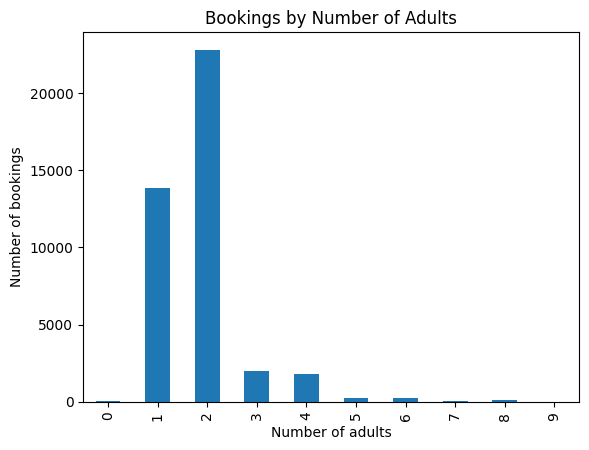

In [18]:
import matplotlib.pyplot as plt

df_bookings_large["srch_adults_cnt"].value_counts().sort_index().plot(kind="bar")
plt.title("Bookings by Number of Adults")
plt.xlabel("Number of adults")
plt.ylabel("Number of bookings")
plt.show()

Party size exhibits a strong skew, with bookings primarily driven by solo travelers and couples. This suggests that party composition is a meaningful contextual feature for ranking hotel clusters.

In [19]:
# create a simple family indicator
df_bookings_large["has_children"] = df_bookings_large["srch_children_cnt"] > 0

df_bookings_large["has_children"].value_counts()


C:\Users\Inbal\AppData\Local\Temp\ipykernel_24268\3353120567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bookings_large["has_children"] = df_bookings_large["srch_children_cnt"] > 0


has_children
False    33525
True      7686
Name: count, dtype: int64

In [20]:
pd.crosstab(
    df_bookings_large["has_children"],
    df_bookings_large["hotel_cluster"]
).loc[True].sort_values(ascending=False).head(5)

hotel_cluster
91    376
48    204
42    200
28    186
18    167
Name: True, dtype: int64

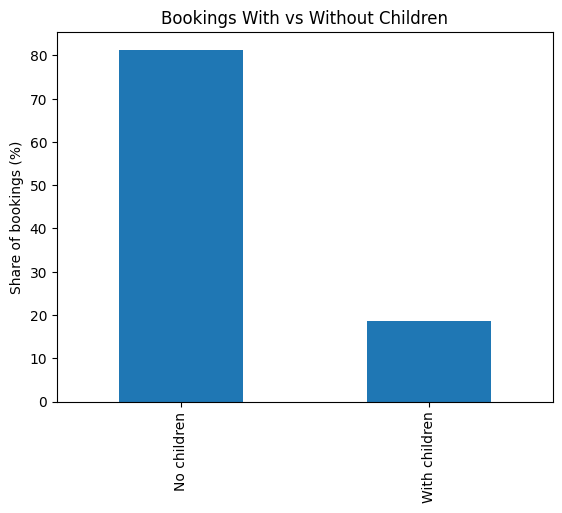

In [39]:
import matplotlib.pyplot as plt

# create binary indicator
df_bookings_large["has_children"] = df_bookings_large["srch_children_cnt"] > 0

# count bookings
children_counts = df_bookings_large["has_children"].value_counts(normalize=True) * 100
children_counts = children_counts.rename({
    False: "No children",
    True: "With children"
})

# plot
children_counts.plot(kind="bar")
plt.title("Bookings With vs Without Children")
plt.ylabel("Share of bookings (%)")
plt.xlabel("")
plt.show()


In [40]:
# create a binary indicator
df_bookings_large["has_children"] = df_bookings_large["srch_children_cnt"] > 0

# absolute counts
counts = df_bookings_large["has_children"].value_counts()

# percentages
percentages = df_bookings_large["has_children"].value_counts(normalize=True) * 100

# combine into one table
summary = (
    pd.DataFrame({
        "bookings": counts,
        "percentage": percentages.round(2)
    })
    .rename(index={False: "Without children", True: "With children"})
)

summary


,bookings,percentage
has_children,,
Without children,33525,81.35
With children,7686,18.65


While most bookings are made by adults-only parties, a substantial minority involve children, indicating the presence of a distinct family segment.

Family bookings account for roughly one-fifth of all booking events. While the most popular hotel clusters remain broadly similar between family and non-family bookings, differences in ranking suggest that party composition influences relative cluster preference rather than introducing entirely distinct clusters.

Family bookings (has_children = True)
Top clusters:
91, 48, 42, 28, 18

##### **Conclusion:** Party size and child presence provide meaningful contextual signals that influence hotel cluster ranking and should be retained as core features.


### 2.3 Temporal Signal (Seasonality & Length of Stay)

##### 2.3.1 Seasonality

In [21]:
pd.to_datetime(df_bookings_large["srch_ci"]).dt.month.value_counts().sort_index()

srch_ci
1     2574
2     2154
3     2658
4     2910
5     3260
6     3556
7     3810
8     4401
9     4018
10    3958
11    3735
12    4177
Name: count, dtype: int64

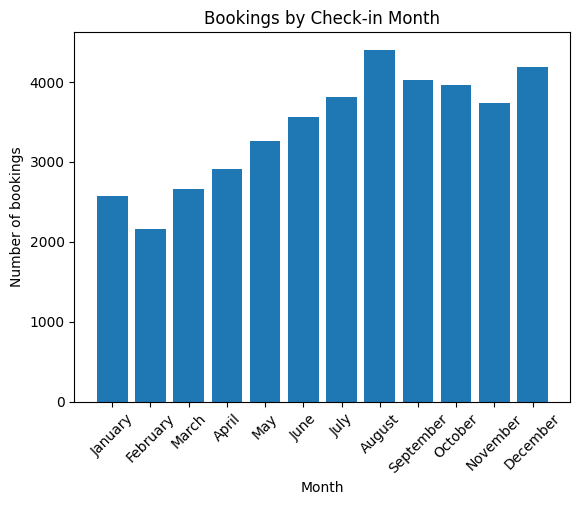

In [22]:
import calendar
import matplotlib.pyplot as plt

month_counts = (
    pd.to_datetime(df_bookings_large["srch_ci"])
    .dt.month
    .value_counts()
    .sort_index()
)

month_labels = [calendar.month_name[m] for m in month_counts.index]

plt.bar(month_labels, month_counts.values)
plt.title("Bookings by Check-in Month")
plt.xlabel("Month")
plt.ylabel("Number of bookings")
plt.xticks(rotation=45)
plt.show()

In [46]:
import pandas as pd
import calendar

df = df_bookings_large.copy()

# ensure datetime
df["srch_ci"] = pd.to_datetime(df["srch_ci"], errors="coerce")

# extract month number
df["checkin_month"] = df["srch_ci"].dt.month

# count bookings per month
monthly_checkin_counts = (
    df["checkin_month"]
    .value_counts()
    .sort_index()
    .to_frame(name="bookings")
)

# add month names (Canva-friendly)
monthly_checkin_counts["month"] = monthly_checkin_counts.index.map(
    lambda m: calendar.month_name[m]
)

# reorder columns
monthly_checkin_counts = monthly_checkin_counts[["month", "bookings"]]

monthly_checkin_counts


,month,bookings
checkin_month,,
1,January,2574
2,February,2154
3,March,2658
4,April,2910
5,May,3260
6,June,3556
7,July,3810
8,August,4401
9,September,4018


In [47]:
monthly_checkin_pct = (
    monthly_checkin_counts
    .assign(percentage=lambda x: (x["bookings"] / x["bookings"].sum() * 100).round(1))
)

monthly_checkin_pct

,month,bookings,percentage
checkin_month,,,
1,January,2574,6.2
2,February,2154,5.2
3,March,2658,6.4
4,April,2910,7.1
5,May,3260,7.9
6,June,3556,8.6
7,July,3810,9.2
8,August,4401,10.7
9,September,4018,9.7


##### Conclusion:
Booking activity shows clear seasonal patterns, with demand peaking during summer months and remaining elevated from late spring through early autumn. This indicates that temporal context—particularly check-in month—is a meaningful signal for ranking hotel clusters and should be incorporated into feature engineering.

##### 2.3.2 Length of Stay

In [23]:
df_bookings_large = df_bookings_large.copy()

df_bookings_large["srch_ci_dt"] = pd.to_datetime(df_bookings_large["srch_ci"])
df_bookings_large["srch_co_dt"] = pd.to_datetime(df_bookings_large["srch_co"])

df_bookings_large["length_of_stay"] = (
    df_bookings_large["srch_co_dt"] - df_bookings_large["srch_ci_dt"]
).dt.days

df_bookings_large["length_of_stay"].describe()



count    41211.000000
mean         2.434326
std          2.064966
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         28.000000
Name: length_of_stay, dtype: float64

Most bookings are short stays (1–3 nights), with a smaller subset of longer stays that may reflect leisure or family travel.

In [24]:
df_bookings_large["stay_type"] = np.where(
    df_bookings_large["length_of_stay"] <= 3,
    "short_stay",
    "long_stay"
)

df_bookings_large["stay_type"].value_counts()

stay_type
short_stay    33046
long_stay      8165
Name: count, dtype: int64

In [25]:
pd.crosstab(
    df_bookings_large["stay_type"],
    df_bookings_large["hotel_cluster"]
).loc["short_stay"].sort_values(ascending=False).head(5)


hotel_cluster
91    1492
48    1058
42     959
59     802
28     800
Name: short_stay, dtype: int64

In [26]:
pd.crosstab(
    df_bookings_large["stay_type"],
    df_bookings_large["hotel_cluster"]
).loc["long_stay"].sort_values(ascending=False).head(5)

hotel_cluster
91    198
65    193
98    166
48    165
64    164
Name: long_stay, dtype: int64

While short stays are dominated by a small set of highly popular hotel clusters, longer stays exhibit a distinct preference pattern, with different clusters entering the top rankings. This suggests that length of stay is an important contextual feature for ranking hotel clusters, particularly for differentiating leisure-oriented bookings from short-term travel.

##### **Conclusion:**  
Length of stay provides a meaningful temporal signal. While short stays dominate overall booking volume, longer stays exhibit different hotel cluster preferences, with distinct clusters entering the top rankings. This indicates that stay duration influences hotel type selection and should be incorporated into feature engineering for ranking hotel clusters.

### 2.4 Distance Signal

In [27]:
df_bookings_large.isnull().sum()

date_time                        0
site_name                        0
posa_continent                   0
user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance    13980
user_id                          0
is_mobile                        0
is_package                       0
channel                          0
srch_ci                          0
srch_co                          0
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
srch_destination_type_id         0
is_booking                       0
cnt                              0
hotel_continent                  0
hotel_country                    0
hotel_market                     0
hotel_cluster                    0
has_children                     0
srch_ci_dt                       0
srch_co_dt                       0
length_of_stay                   0
stay_type           

**Note on Missing Values:**  
Missing values are confined almost entirely to the distance feature (`orig_destination_distance`), affecting approximately 34% of booking events. This missingness is treated as an informative signal and analyzed as part of the distance feature exploration.

In [28]:
df_bookings_large["orig_destination_distance"].isnull().mean()


0.3392298172817937

In [29]:
df_bookings_large["orig_destination_distance"].describe()

count    27231.000000
mean      1680.797723
std       2124.722814
min          0.005600
25%        224.219100
50%        817.488500
75%       2243.289450
max      11641.224200
Name: orig_destination_distance, dtype: float64

For bookings where distance is known:

- Median ≈ 817 km → many regional / intra-continent trips

- 25% ≤ 224 km → short-distance travel is common

- Long tail up to ~11,600 km → intercontinental trips

- Very wide spread → distance is not linear, needs bucketing

Travel distance varies widely, from local trips to long-haul journeys, suggesting that absolute distance is less informative than distance categories (e.g., near vs far).

Combined with earlier finding:

~34% distance missing
→ missingness itself is informative

For modeling later:

Keep orig_destination_distance

Add:

- distance_missing flag

- distance buckets (not raw value)

In [30]:
# “Does missing distance behave differently?”
df_bookings_large["distance_missing"] = df_bookings_large["orig_destination_distance"].isnull()

df_bookings_large["distance_missing"].value_counts(normalize=True)


distance_missing
False    0.66077
True     0.33923
Name: proportion, dtype: float64

In [31]:
# Top clusters when distance is missing:
pd.crosstab(
    df_bookings_large["distance_missing"],
    df_bookings_large["hotel_cluster"]
).loc[True].sort_values(ascending=False).head(5)

hotel_cluster
82    445
46    392
64    356
59    355
2     299
Name: True, dtype: int64

- These clusters are not identical to the global top clusters

- This means missing distance is associated with different booking behavior

👉 Missingness is informative, not random.

When distance information is unavailable, booking behavior shifts toward a different set of hotel clusters. This suggests that distance missingness reflects distinct user contexts (e.g., lower geographic resolution or international searches) and should be modeled explicitly rather than imputed away

##### **Conclusion:**  
Distance between user and destination exhibits a wide range and a long-tailed distribution, indicating that absolute distance should be treated in coarse categories rather than as a raw continuous value. Approximately one-third of booking events lack distance information, and these cases are associated with distinct hotel cluster preferences. Therefore, both distance buckets and a distance-missing indicator are retained as informative signals.

In [43]:
import pandas as pd

df = df_bookings_large.copy()

missing_summary = (
    df["orig_destination_distance"]
    .isna()
    .value_counts(normalize=True) * 100
).round(2)

missing_summary = missing_summary.rename({
    True: "Missing distance",
    False: "Distance available"
})

missing_summary


orig_destination_distance
Distance available    66.08
Missing distance      33.92
Name: proportion, dtype: float64

In [44]:
import numpy as np

df = df_bookings_large.copy()

distance_bins = [0, 100, 500, 2000, 10000, np.inf]
distance_labels = [
    "Local (<100 km)",
    "Short (100–500 km)",
    "Medium (500–2,000 km)",
    "Long (2,000–10,000 km)",
    "Very long (>10,000 km)"
]

df["distance_bucket"] = pd.cut(
    df["orig_destination_distance"],
    bins=distance_bins,
    labels=distance_labels
)

distance_distribution = (
    df["distance_bucket"]
    .value_counts(normalize=True)
    .sort_index() * 100
).round(1)

distance_distribution


distance_bucket
Local (<100 km)           12.4
Short (100–500 km)        28.1
Medium (500–2,000 km)     31.4
Long (2,000–10,000 km)    27.5
Very long (>10,000 km)     0.6
Name: proportion, dtype: float64

### 2.5 Device & Channel Signal

##### 2.5.1 Mobile vs desktop

In [32]:
df_bookings_large["is_mobile"].value_counts(normalize=True)


is_mobile
0    0.905365
1    0.094635
Name: proportion, dtype: float64

In [33]:
# Do mobile users prefer different hotel clusters?
pd.crosstab(
    df_bookings_large["is_mobile"],
    df_bookings_large["hotel_cluster"]
).loc[1].sort_values(ascending=False).head(5)

hotel_cluster
91    170
48    113
42    112
18     92
28     92
Name: 1, dtype: int64

Compare to desktop: These are largely the same dominant clusters

No clearly “mobile-only” cluster emerges

Mobile usage does not introduce distinct hotel cluster preferences, but may slightly affect ranking strength.

So:

is_mobile = secondary signal

##### 2.5.2 Package vs non-package

In [34]:
# check whether package bookings (flight + hotel) behave differently.
df_bookings_large["is_package"].value_counts(normalize=True)


is_package
0    0.857247
1    0.142753
Name: proportion, dtype: float64

Most bookings are hotel-only, but a meaningful minority are part of travel packages, which may reflect different user intent (e.g., leisure vs. business).

In [35]:
# Do package bookings prefer different hotel clusters?

pd.crosstab(
    df_bookings_large["is_package"],
    df_bookings_large["hotel_cluster"]
).loc[1].sort_values(ascending=False).head(5)

hotel_cluster
65    191
1     173
98    146
64    144
95    131
Name: 1, dtype: int64

In [45]:
import pandas as pd

package_summary = (
    df_bookings_large["is_package"]
    .value_counts(normalize=True) * 100
).round(2)

package_summary = package_summary.rename({
    0: "Non-package bookings",
    1: "Package bookings"
})

package_summary



is_package
Non-package bookings    85.72
Package bookings        14.28
Name: proportion, dtype: float64


Top clusters for package bookings:
65, 1, 98, 64, 95

Compare this to non-package / overall bookings, which were dominated by:
91, 48, 42, 28, ...

These are clearly different clusters.
Package bookings exhibit distinct hotel cluster preferences.

While device type shows limited impact on hotel cluster preference, package bookings exhibit a distinct ranking of preferred hotel clusters compared to hotel-only bookings. This indicates that package context captures meaningful differences in user intent and should be retained as an important feature for ranking hotel clusters.

##### **Conclusion:**  
Device type shows limited differentiation in hotel cluster preferences, suggesting a modest impact on ranking outcomes. In contrast, package bookings display distinct cluster preferences, reflecting different user intent and travel patterns. Therefore, package context is retained as a meaningful feature, while device type is treated as a secondary signal.

-----

### Correlations

❌ Correlations are not essential here, because:

- most features are categorical IDs

- correlation matrices:

1. are hard to interpret

2. don’t map well to MAP@5

3. are weak for PM storytelling

## EDA Output

### Strong “keep” features

**Geography**

- user_location_country

- user_location_region

- srch_destination_id

**Search intent**

- srch_adults_cnt

- srch_children_cnt / has_children

- length_of_stay

- stay_type

- srch_destination_type_id

**Time**

- check-in month (derived from srch_ci)

**Distance**

- distance buckets

-distance_missing flag

**Commercial context**

- is_package

### Secondary / cautious features

- is_mobile

- channel

- user_location_city (very high cardinality)

- hotel attributes (possible exposure bias)

### Exclude as features

- hotel_cluster (target)

- is_booking (filter only)

- cnt (weight, not feature)

- raw timestamps